In [17]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io
import os
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [18]:
def read_symbols(filename):
    with open(filename) as f:
        temp = [line.strip() for line in f.readlines()]
    return temp

In [29]:
### Contains the symbols of S&P 500 stocks
filename = 'data/SP-500.txt'
### To download data for the stocks for a month (actually just 21 days) (every 5 min) 
start = datetime.datetime(2021,12,1)
end = datetime.datetime(2021,12,31)

In [32]:
### Get symbols in a list from the TXT file
symbols = read_symbols(filename)

### Download stocks from YFinance

In [33]:
"""stock_final = {}
# iterate over each symbol
for i in symbols:  
    
    # print the symbol which is being downloaded
    print( str(symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    try:
        # download the stock price 
        stock = yf.download(i,interval='5m',start=start, end=end)        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            ## Add to the dict , where the key is the symbol of the stock 
            ## And the value is the df of history prices
            stock_final[i]= stock
    except Exception:
        None"""

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Save the stocks as CSV files

In [35]:
## save the dataframes
"""for key in stock_final.keys():
    stock_final[key].to_csv('data/2021-december/'+key+'.csv')"""

In [62]:
stock_final['LSI'].tail()

,Datetime,Open,High,Low,Close,Adj Close,Volume
1631,2021-12-30 15:35:00-05:00,152.419998,152.470001,152.050003,152.240005,152.240005,11920
1632,2021-12-30 15:40:00-05:00,152.169998,152.250000,151.929993,151.960007,151.960007,7762
1633,2021-12-30 15:45:00-05:00,151.970001,152.080002,151.770004,151.970001,151.970001,15912
1634,2021-12-30 15:50:00-05:00,151.880005,151.990005,151.619995,151.800003,151.800003,13633
1635,2021-12-30 15:55:00-05:00,151.830002,152.095001,151.520004,151.919998,151.919998,60365


In [53]:
for stock , data in stock_final.items():
    print(stock)
    print(stock_final[stock].shape)

BBBY
(1638, 7)
SBUX
(1638, 7)
LSI
(1636, 7)
ADP
(1638, 7)
MCK
(1639, 7)
ADM
(1638, 7)
CPB
(1638, 7)
GME
(1638, 7)
EXPE
(1638, 7)
C
(1638, 7)
MU
(1638, 7)
AAPL
(1638, 7)
SCHW
(1638, 7)
EMN
(1636, 7)
MAS
(1638, 7)
PSA
(1637, 7)
XLNX
(1638, 7)
FFIV
(1613, 7)
HOG
(1638, 7)
CCL
(1638, 7)
KO
(1639, 7)
HAS
(1638, 7)
OMC
(1638, 7)
AMD
(1638, 7)
DG
(1638, 7)
GCI
(1637, 7)
JCI
(1638, 7)
TMO
(1638, 7)
FISV
(1638, 7)
NSC
(1637, 7)
CSX
(1638, 7)
CTSH
(1638, 7)
PXD
(1638, 7)
DFS
(1638, 7)
MTB
(1638, 7)
MSI
(1637, 7)
CMI
(1638, 7)
UNH
(1638, 7)
F
(1638, 7)
MDLZ
(1638, 7)
JWN
(1638, 7)
HD
(1638, 7)
LRCX
(1638, 7)
RF
(1638, 7)
FE
(1638, 7)
TROW
(1638, 7)
MNST
(1638, 7)
JNJ
(1638, 7)
MRO
(1638, 7)
IPG
(1639, 7)
XEL
(1638, 7)
CHK
(1637, 7)
WDC
(1638, 7)
VNO
(1638, 7)
VLO
(1638, 7)
NOV
(1638, 7)
GT
(1638, 7)
AXP
(1638, 7)
MAT
(1638, 7)
ZION
(1638, 7)
LMT
(1639, 7)
FAST
(1638, 7)
DGX
(1638, 7)
DIS
(1638, 7)
EXPD
(1639, 7)
AEE
(1638, 7)
BA
(1638, 7)
EXC
(1638, 7)
HST
(1638, 7)
CTXS
(1637, 7)
PBI
(1638, 7)
P

### Read stocks from CSV files

In [36]:
stock_final = {}
path = 'data/2021-december/'
files = os.listdir(path)
for file in files:
    stock_final[file[:-4]] = pd.read_csv(path+file)

## Find the cointegrated pairs
* Stock X and Stock Y are cointegrate means $ Z_t  = X_t - \beta Y_t $ Where $ Z_t$ Should be stationary.
* And Since we don't know $ \beta $, we should estimate it first ( using Linear regression for instance)
* then Test for the stationarity of $Z_t$ using ADF test 

#### Get the $\beta$ for every pairs

In [52]:
symbols = list(stock_final.keys())

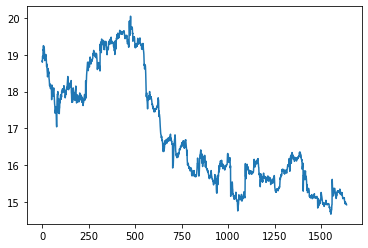

In [48]:
plt.plot(stock_final['BBBY'].Close.tolist())

In [50]:
### This step takes few mins
nbr_stocks = len(symbols)
beta = {}
for i in range(nbr_stocks):
    for j in range(i+1,nbr_stocks):
        model = sm.OLS(stock_final[symbols[i]].Close,stock_final[symbols[j]].Close)
        res = model.fit()
        beta[(symbols[i],symbols[j])] = res.params[0]

ValueError: endog and exog matrices are different sizes

In [14]:
len(beta)

57630

### The most cointegrated pair

In [10]:
min(beta, key=beta.get)

('BBBY', 'MCK')

#### Calculate the spread using the following formula $ U_t = X_t - \beta Y_t$

In [16]:
spreads = {}
for pair , b in beta.items():
    spreads[pair] = stock_final[pair[0]].Close - b * stock_final[pair[1]].Close

#### ADF test for the stationarity of the spread

In [26]:
def get_adf_p_value(spread):
    """Spread is the difference betweek 2 stocks with a constant Beta"""
    return adfuller(spread)[1]

In [39]:
pairs_ADF = {}
for pair, spread in spreads.items():
    pairs_ADF[pair] = get_adf_p_value(spread)

### Choosing the cointegrated pairs by putting a treshold of the p-value

In [44]:
p_value_treshold = 0.005
cointegrated_pairs = []
for pair in pairs_ADF.keys():
    if pairs_ADF[pair] < p_value_treshold:
        cointegrated_pairs.append(pair)

In [45]:
len(cointegrated_pairs)

7076

!!!! Too much cointegrated pairs